In [1]:
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms as tt
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score,precision_score

In [2]:
import sys
sys.path.append('/kaggle/input/torchkit')

import ImageClassifier as ic

In [3]:
stats=([0.485,0.456,0.406],[0.229,0.224,0.225])

train_transform=tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomRotation(10),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

val_test_transform=tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [4]:
train_ds=ImageFolder('/kaggle/input/cards-image-datasetclassification/train',transform=train_transform)
test_ds=ImageFolder('/kaggle/input/cards-image-datasetclassification/test',transform=val_test_transform)
valid_ds=ImageFolder('/kaggle/input/cards-image-datasetclassification/valid',transform=val_test_transform)

len(train_ds),len(test_ds),len(valid_ds)

(7624, 265, 265)

In [5]:
bs=128
train_dl=DataLoader(train_ds,batch_size=bs,shuffle=True,pin_memory=True)
test_dl=DataLoader(test_ds,batch_size=bs*2,shuffle=True,pin_memory=True)
valid_dl=DataLoader(valid_ds,batch_size=bs*2,shuffle=True,pin_memory=True)

In [6]:
classes=train_ds.classes
len(classes)

53

In [7]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label: ', classes[label], '(', str(label), ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)


Label:  ace of clubs ( 0 )


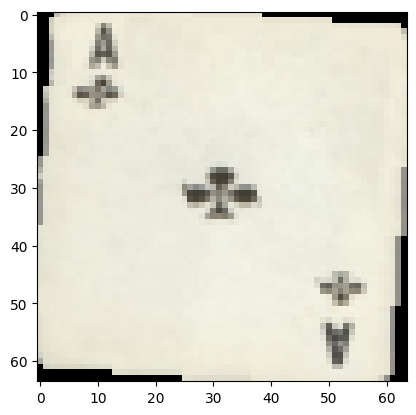

In [8]:
img,label=train_ds[100]
show_image(img,label)

Label:  eight of hearts ( 6 )


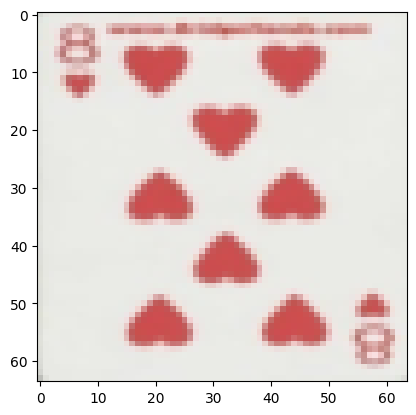

In [9]:
img,label=train_ds[1000]
show_image(img,label)

In [11]:
def conv_block(in_channels,out_channels,pool=False):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
           nn.BatchNorm2d(out_channels),
           nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Cards(ic.ImageModel):
    
    def __init__(self,in_channels,num_classes):
        super().__init__()
        
        self.conv1=conv_block(in_channels,64)
        self.conv2=conv_block(64,128,pool=True)
        self.res1=nn.Sequential(conv_block(128,128),conv_block(128,128))
        
        self.conv3=conv_block(128,256,pool=True)
        self.conv4=conv_block(256,512,pool=True)
        self.res2=nn.Sequential(conv_block(512,512),conv_block(512,512))
        
        self.classifier=nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                     nn.Flatten(),
                                     nn.Dropout(0.2),
                                     nn.Linear(512,num_classes))
        
    def forward(self,xb):
        out=self.conv1(xb)
        out=self.conv2(out)
        out=self.res1(out)+out
        out=self.conv3(out)
        out=self.conv4(out)
        out=self.res2(out)+out
        out=self.classifier(out)
        return out

In [18]:
lr=0.001
wd=1e-4
gc=0.1
epochs=25

In [19]:
model=Cards(3,len(classes))

In [20]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.AdamW(model.parameters(),lr=lr,weight_decay=wd)
sched=optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,epochs=epochs,steps_per_epoch=len(train_dl))

In [21]:
model.compile(loss_fn=loss_fn,
             optimizer=optimizer,
             scheduler=sched,
             grad_clip=gc)

In [22]:
import time
start=time.time()

history=model.fit(epochs=epochs,train_loader=train_dl,val_loader=valid_dl)

print(f'Time taken for training: {(time.time()-start)/60} minutes')

Training on cuda
Epoch [1], train_loss: 4.2322, train_acc: 0.0679, val_loss: 2.9859, val_acc: 0.2185
Epoch [2], train_loss: 2.9402, train_acc: 0.2171, val_loss: 1.5415, val_acc: 0.6144
Epoch [3], train_loss: 2.4636, train_acc: 0.3271, val_loss: 2.0210, val_acc: 0.3709
Epoch [4], train_loss: 2.1404, train_acc: 0.4303, val_loss: 1.4208, val_acc: 0.6224
Epoch [5], train_loss: 1.8052, train_acc: 0.5214, val_loss: 1.3869, val_acc: 0.6020
Epoch [6], train_loss: 1.5818, train_acc: 0.5775, val_loss: 0.9068, val_acc: 0.7346
Epoch [7], train_loss: 1.4436, train_acc: 0.6110, val_loss: 0.8794, val_acc: 0.7522
Epoch [8], train_loss: 1.3002, train_acc: 0.6419, val_loss: 0.9248, val_acc: 0.7444
Epoch [9], train_loss: 1.1493, train_acc: 0.6792, val_loss: 0.4950, val_acc: 0.8566
Epoch [10], train_loss: 0.9960, train_acc: 0.7157, val_loss: 0.5749, val_acc: 0.8049
Epoch [11], train_loss: 0.8644, train_acc: 0.7559, val_loss: 0.4636, val_acc: 0.8741
Epoch [12], train_loss: 0.7880, train_acc: 0.7743, val_lo

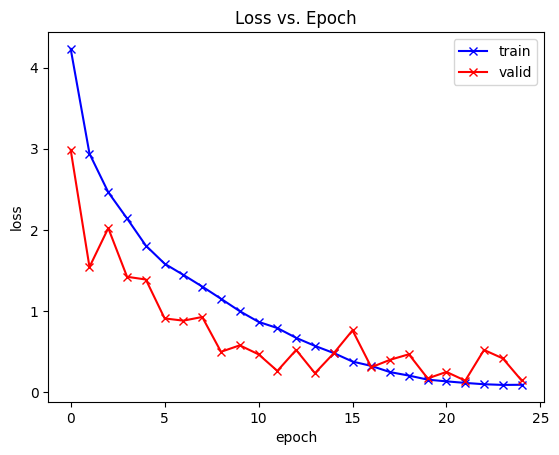

In [23]:
model.plot_losses()

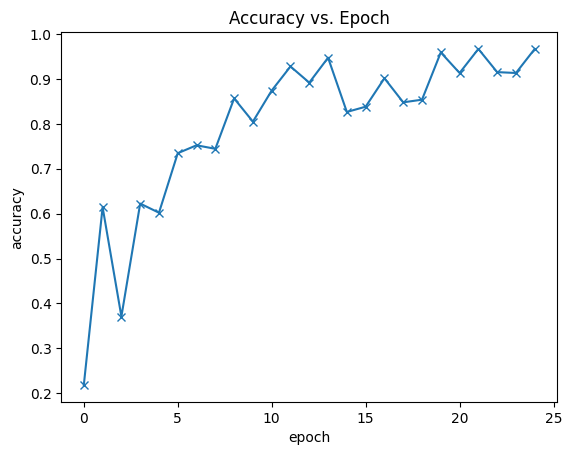

In [24]:
model.plot_accuracies()

In [25]:
model.metrics(train_ds)

(0.994884575026233, 0.9948068042684683, 0.9948520117928787)

In [26]:
model.metrics(valid_ds)

(0.9358490566037736, 0.9339663481172914, 0.9454627133872417)

In [30]:
model.metrics(test_ds)

(0.9056603773584906, 0.8955260672241803, 0.906581311769991)